In [17]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import polars as pl
from datetime import timedelta
import datetime 
import json 
import toml
import holidays
import sys

features = toml.load(r'C:\Users\N000193384\Documents\sncf_project\sncf_playground\data\features.toml')
times_cols = features['times_cols']
macro_horizon = features['MACRO_HORIZON']
p = Path(features['ABS_DATA_PATH'])
sys.path.insert(1, p)

from src.preprocessing.times import (
    from_day_to_time_fe,
    get_covid_table,
)
from src.preprocessing.quality import trim_timeseries, minimum_length_uid
from src.models.forecast.direct import DirectForecaster
from src.preprocessing.lags import get_significant_lags
from src.preprocessing.times import get_basic_holidays
from src.project_utils import load_data
from src.models.lgb_wrapper import GBTModel
from src.preprocessing.validation import freeze_validation_set
from src.preprocessing.lags import compute_autoreg_features

ts_uid = features["ts_uid"]
date_col = features['date_col']
y = features['y']
submit = False 
flist = features["flist"]
long_horizon = np.arange(macro_horizon)
chains = np.array_split(long_horizon, 6)
exog = ["job", "ferie", "vacances"] + times_cols

with open('data/params.json', 'rb') as stream:
    params_q = json.load(stream)

in_dt = datetime.date(2020, 6, 1)

covid_df = get_covid_table(2015, 2024)
df_dates = df_dates = get_basic_holidays()
holidays_fe = list(filter(lambda x: date_col not in x, df_dates.columns))
covid_fe = list(filter(lambda x: date_col not in x, covid_df.columns))
exog = exog + holidays_fe + covid_fe

train_data, test_data, submission = load_data(p)

test_data = (
    test_data.pipe(from_day_to_time_fe, time=date_col, frequency="day")
    .join(df_dates, how="left", on=[date_col])
    .join(covid_df, how="left", on=[date_col])
)

train_data = (
    train_data.pipe(trim_timeseries, target="y", uid=ts_uid, time=date_col)
    .pipe(from_day_to_time_fe, time=date_col, frequency="day")
    .join(df_dates, how="left", on=[date_col])
    .join(
        covid_df.with_columns(
            pl.lit(np.where(np.any(covid_df != 0, axis=1), 0.01, 1)).alias(
                "covid_weight"
            )
        ),
        how="left",
        on=[date_col],
    )
    # sncf strike | 2019-12-01 to 2021-11-01
    .filter(
        (pl.col(date_col) >= in_dt)
        & (pl.col(date_col) != pl.datetime(2019, 12, 1))
        & (pl.col(date_col) != pl.datetime(2021, 11, 1))
    )
)

good_ts = minimum_length_uid(
    train_data, uid=ts_uid, time=date_col, min_length=round(364 * 1.2)
)
train_data = train_data.filter(pl.col(ts_uid).is_in(good_ts))
# test.
left_term = train_data.select([date_col, ts_uid, "y"] + exog).with_columns(
    pl.lit(1).alias("train")
)
right_term = test_data.select([date_col, ts_uid, "y"] + exog).with_columns(
    pl.lit(0).alias("train")
)
full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
del left_term, right_term

# define params
significant_lags = get_significant_lags(train_data, date_col=date_col, target=y)
significant_lags = [x for x in significant_lags if x%7 == 0 and x<= macro_horizon][1:]

autoreg_dict = {
        ts_uid: {
            "groups": ts_uid,
            "horizon": lambda horizon: np.int32(horizon),
            "wins": np.array([28, 56]),
            "shifts": lambda horizon: np.int32([horizon]),
            "lags": lambda horizon: np.array(significant_lags) + horizon,
            "funcs": np.array(flist),
        },
        "ts_uid_dow": {
            "groups": [ts_uid, "day_of_week"],
            "horizon": lambda horizon: np.int32(np.ceil(horizon / 7) + 1),
            "wins": np.array([4, 8]),
            "shifts": lambda horizon: np.int32([np.ceil(horizon / 7) + 1]),
            "lags": lambda horizon: np.arange(1, 7) + np.ceil(horizon / 7) + 1,
            "funcs": np.array(flist),
        }
    }

for key in autoreg_dict.keys():
    autoreg_dict[key]["horizon"] = autoreg_dict[key]["horizon"](macro_horizon)
    autoreg_dict[key]["shifts"] = autoreg_dict[key]["shifts"](macro_horizon)
    autoreg_dict[key]["lags"] = autoreg_dict[key]["lags"](macro_horizon)

cat_cols = ['week', 'month', 'day_of_week', "job", "ferie", "vacances"]
target = "y"

In [18]:
'''import os
from typing import Dict, List

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def objective(
    trial: optuna.trial,
    train_data: pd.DataFrame,
    exog: List,
    seed: int = 12345,
):
    """_summary_

    Args:
        trial (optuna.trial): _description_
        train_x (pd.DataFrame): _description_
        test (pd.DataFrame): _description_
        features (List): _description_
        target (sself, optional): _description_. Defaults to "".
        seed (int, optional): _description_. Defaults to 12345.

    Returns:
        _type_: _description_
    """
    optuna_params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": trial.suggest_categorical(
            "objective", ["regression", "huber", "regression_l1", "quantile"]
        ),
        "metric": trial.suggest_categorical("metric", ["rmse"]),
        "alpha": trial.suggest_categorical(
            "alpha",
            [0.5, 0.52, 0.55, 0.57, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.69, 0.7],
        ),
        "force_row_wise": trial.suggest_categorical("force_row_wise", [True, False]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=False),
        "max_depth": trial.suggest_int("max_depth", 4, 15),
        "sub_row": trial.suggest_categorical("sub_row", [0.6, 0.7, 0.8, 1.0]),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 4, log=True),
        "min_child_samples": trial.suggest_float(
            "min_child_samples", 20, 5000, log=False
        ),
        "num_iterations": trial.suggest_int(
            "n_estimators",
            200,
            3000,
        ),
        "num_leaves": trial.suggest_int("num_leaves", 25, 800),
        "max_bins": trial.suggest_int("max_bins", 24, 1000),
        "min_data_in_bin": trial.suggest_int("min_data_in_bin", 25, 1000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 1000),
        "feature_fraction_seed": trial.suggest_categorical(
            "feature_fraction_seed", [seed]
        ),
        "bagging_seed": trial.suggest_categorical("bagging_seed", [seed]),
        "seed": trial.suggest_categorical("seed", [seed]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
    }

    horizon = 181
    lags = [x for x in significant_lags if x <= horizon]
    win_list =  [ x for x in significant_lags if x % 7 == 0 and x <= horizon][1:] 

    autoreg_dict = {
        ts_uid : {
            'groups' : ts_uid,
            'horizon': lambda horizon : np.int32(horizon),
            'wins' : np.array(win_list), 
            'shifts' : lambda horizon : np.int32([horizon, horizon+28, horizon+56]), 
            'lags' : lambda horizon : np.array(significant_lags) + horizon,
            'funcs' : np.array(flist)
        },
        "ts_uid_dow" : {
            'groups':[ts_uid, 'day_of_week'],
            'horizon' : lambda horizon : np.int32(np.ceil(horizon /7) + 1),
            'wins' : np.array([4, 8, 12, 16, 20]), 
            'shifts' : lambda horizon : np.int32([np.ceil(horizon /7) + 1, np.ceil(horizon /7) + 4]), 
            'lags' : lambda horizon : np.arange(1, 7) + np.ceil(horizon/7)+1,
            'funcs' : np.array(flist)
        }
    }


    effect_m = GBTModel(params=optuna_params, 
                        early_stopping_value=200, 
                        features= None,
                        custom_loss=optuna_params["objective"], 
                        categorical_features=[]
                        )


    dir_forecaster = DirectForecaster(
        model=effect_m,
        ts_uid=ts_uid,
        forecast_range=np.arange(horizon),
        target_str="y",
        date_str="date",
        exogs=exog,
        features_params=autoreg_dict
    )

    dir_forecaster.fit(train_data=train_data)
    return dir_forecaster.evaluate()["mae"].values[0]


def parameters_tuning(
    initial_params: Dict,
    tuning_objective,
    n_trials: int = 25,
    njobs: int = -1,
):
    """parameter for tuning over sudy

    Args:
        tuning_objective (_type_): _description_
        n_trials (int, optional): _description_. Defaults to 25.

    Returns:
        _type_: _description_

    example :

    func = lambda trial: objective(trial=trial,
                                    train_x=train_x,
                                    test=residualised_test,
                                    covariates=covariates,
                                    target=y,
                                    seed=12345
                                    )
    study_df, best_params = parameters_tuning(tuning_objective=func, n_trials=25, initial_params={})
        print(best_params)
        print(study_df)
        study_df.to_csv('bparamslgb_new.csv', sep="|", index=False)
    """
    study = optuna.create_study(direction="minimize")
    # study.enqueue_trial(initial_params)
    study.optimize(tuning_objective, n_trials=n_trials, n_jobs=njobs)
    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    study_df = study.trials_dataframe()
    return study_df, study.best_params


func = lambda trial: objective(trial=trial,
                                train_data=train_data,
                                exog=exog,
                                seed=12345
                                )
study_df, best_params = parameters_tuning(tuning_objective=func, n_trials=30, initial_params={}, njobs=10)
print(best_params)
print(study_df)
study_df.to_csv('bparamslgb_new.csv', sep="|", index=False)'''

'import os\nfrom typing import Dict, List\n\nimport lightgbm as lgb\nimport numpy as np\nimport optuna\nimport pandas as pd\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import train_test_split\n\n\ndef objective(\n    trial: optuna.trial,\n    train_data: pd.DataFrame,\n    exog: List,\n    seed: int = 12345,\n):\n    """_summary_\n\n    Args:\n        trial (optuna.trial): _description_\n        train_x (pd.DataFrame): _description_\n        test (pd.DataFrame): _description_\n        features (List): _description_\n        target (sself, optional): _description_. Defaults to "".\n        seed (int, optional): _description_. Defaults to 12345.\n\n    Returns:\n        _type_: _description_\n    """\n    optuna_params = {\n        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),\n        "objective": trial.suggest_categorical(\n            "objective", ["regression", "huber", "regression_l1", "quantile"]\n        ),\n      

In [68]:
import pandas as pd
import numpy as np

from pathlib import Path
from IPython.display import display
import polars as pl
import datetime
import json
import toml
import sys
import argparse
from copy import deepcopy
from datetime import timedelta


sys.path.insert(0, r"C:\Users\N000193384\Documents\sncf_project\sncf_playground")

from src.preprocessing.times import (
    from_day_to_time_fe,
    get_covid_table,
)
from src.preprocessing.quality import trim_timeseries, minimum_length_uid
from src.models.forecast.direct import DirectForecaster
from src.preprocessing.lags import get_significant_lags
from src.preprocessing.times import get_basic_holidays

# metrics of the competition.
from src.project_utils import load_data
from src.models.lgb_wrapper import GBTModel

features = toml.load("data/features.toml")

times_cols = features["times_cols"]
macro_horizon = features["MACRO_HORIZON"]
p = Path(features["ABS_DATA_PATH"])
ts_uid = features["ts_uid"]
date_col = features["date_col"]
y = features["y"]
flist = features["flist"]
exog = ["job", "ferie", "vacances"] + times_cols
in_dt = datetime.date(2017, 1, 1)
parser = argparse.ArgumentParser()
parser.add_argument("--strategy", default="global", required=True)

if __name__ == "__main__":

    set_strategy = "global"
    params_file_name = "params" if set_strategy == "global" else "individual_params"
    with open(f"data/{params_file_name}.json", "rb") as stream:
        params_q = json.load(stream)

    covid_df = get_covid_table(2015, 2024)
    df_dates = df_dates = get_basic_holidays()
    holidays_fe = list(filter(lambda x: date_col not in x, df_dates.columns))
    covid_fe = list(filter(lambda x: date_col not in x, covid_df.columns))
    exog = exog + holidays_fe + covid_fe

    train_data, test_data, submission = load_data(p)

    test_data = (
        test_data.pipe(from_day_to_time_fe, time=date_col, frequency="day")
        .join(df_dates, how="left", on=[date_col])
        .join(covid_df, how="left", on=[date_col])
    )

    train_data = (
        train_data.pipe(trim_timeseries, target="y", uid=ts_uid, time=date_col)
        .pipe(from_day_to_time_fe, time=date_col, frequency="day")
        .join(df_dates, how="left", on=[date_col])
        .join(
            covid_df.with_columns(
                pl.lit(np.where(np.any(covid_df != 0, axis=1), 0, 1)).alias(
                    "covid_weight"
                )
            ),
            how="left",
            on=[date_col],
        )
        # sncf strike | 2019-12-01 to 2021-11-01
        .filter(
            (pl.col(date_col) >= in_dt)
            & (pl.col(date_col) != pl.datetime(2019, 12, 1))
            & (pl.col(date_col) != pl.datetime(2021, 11, 1))
        )
    )

    # add exponentiel time weight over covid weight
    train_data = train_data.with_columns(
        (
            pl.col("covid_weight")
            + pl.col(date_col).cast(pl.String).cast(pl.Categorical).to_physical()
        ).alias("covid_weight")
    )

    good_ts = minimum_length_uid(
        train_data, uid=ts_uid, time=date_col, min_length=round(364 * 1.2)
    )
    train_data = train_data.filter(pl.col(ts_uid).is_in(good_ts))
    # test.
    left_term = train_data.select([date_col, ts_uid, "y"] + exog).with_columns(
        pl.lit(1).alias("train")
    )
    right_term = test_data.select([date_col, ts_uid, "y"] + exog).with_columns(
        pl.lit(0).alias("train")
    )
    full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
    del left_term, right_term

    # define params
    significant_lags = get_significant_lags(train_data, date_col=date_col, target=y)
    significant_lags = [
        x for x in significant_lags if x <= macro_horizon and x % 7 == 0
    ]

    if set_strategy == "global":
        model_reg = GBTModel(
            params=params_q,
            early_stopping_value=200,
            features=None,
            custom_loss=params_q["objective"],
            weight="covid_weight",
            categorical_features=[],
        )

    else:
        from src.models.scikit_wrapper import ScikitWrapper
        from sklearn.ensemble import RandomForestRegressor

        model_reg = ScikitWrapper(
            model=RandomForestRegressor(
                max_depth=11,
                n_estimators=200,
                n_jobs=-1,
                min_samples_split=20,
                min_samples_leaf=15,
                max_features=0.85,
                random_state=42,
                ccp_alpha=0.3,
            ),
            params=None,
            features=None,
            categorical_features=[],
            weight="covid_weight",
        )

    lags = deepcopy(significant_lags)
    win_list = [7, 28, 56]

    autoreg_dict = {
        ts_uid: {
            "groups": ts_uid,
            "horizon": lambda horizon: np.int32(horizon),
            "wins": np.array(win_list),
            "shifts": lambda horizon: np.int32([horizon, horizon + 28]),
            "lags": lambda horizon: np.array(significant_lags) + horizon,
            "funcs": np.array(flist),
        },
        "ts_uid_dow": {
            "groups": [ts_uid, "day_of_week"],
            "horizon": lambda horizon: np.int32(np.ceil(horizon / 7) + 1),
            "wins": np.array([4, 12]),
            "shifts": lambda horizon: np.int32(
                [
                    np.ceil(horizon / 7) + 1,
                    np.ceil(horizon / 7) + round((macro_horizon / 4)),
                ]
            ),
            "lags": lambda horizon: np.arange(1, 7) + np.ceil(horizon / 7) + 1,
            "funcs": np.array(flist),
        },
    }

    for transform_strategy in [
        # "rolling_zscore",
        # "shiftn",
        # "None",
        # "rolling_mean",
        # "rolling_median",
        "log",
        #"mean",
        #"median",
    ]:
        print("=" * 50)
        print(f"running with {transform_strategy = }")
        print("=" * 50)

        dir_forecaster = DirectForecaster(
            model=model_reg,
            ts_uid=ts_uid,
            forecast_range=np.arange(macro_horizon),
            target_str=y,
            date_str=date_col,
            exogs=exog,
            features_params=autoreg_dict,
            n_jobs=-1,
            transform_strategy=transform_strategy,
            transform_win_size=28 * 2,
        )
        # fit model through the wrapper
        dir_forecaster.fit(
            deepcopy(train_data),
            strategy=set_strategy,
        )
        display(dir_forecaster.evaluate())
        name_out = dir_forecaster.output_name
        # and forecast test.
        test_output = (
            test_data.select(["index", date_col, ts_uid])
            .join(
                (
                    dir_forecaster.predict(full_data)
                    .filter(pl.col("train") == 0)
                    .select([date_col, ts_uid, name_out])
                ),
                how="left",
                on=[date_col, ts_uid],
            )
            .select(["index", "y_hat"])
            .rename({"y_hat": "y"})
        )
        test_output.fill_null(0).write_csv(
            f"out/submit/{set_strategy}_direct_{transform_strategy}_lgb.csv"
        )

        # write valid for evaluation purpose.
        if set_strategy == "global":
            valid_out = (dir_forecaster.target_transformer.inverse_transform(
                dir_forecaster.predict_global(dir_forecaster.valid),
                target=dir_forecaster.output_name
                ).rename({dir_forecaster.output_name : f"{set_strategy}_direct_{transform_strategy}_y_hat"})
                .drop(dir_forecaster.target_transformer.agg_fname)
            valid_out = dir_forecaster.target_transformer.inverse_transform(
                valid_out,
                target=dir_forecaster.target_str
                )
        else:
            hat = dir_forecaster.predict_local(dir_forecaster.valid)
            hat = dir_forecaster.target_transformer.inverse_transform(
                hat, target=dir_forecaster.output_name
            )
            valid_out = hat.select([ts_uid, date_col, "y_hat"]).rename(
                {"y_hat": f"{set_strategy}_direct_{transform_strategy}_y_hat"}
            )

        valid_out.write_csv(f"out/{set_strategy}_{transform_strategy}_direct_lgb.csv")


running with transform_strategy = 'log'


c:\Users\N000193384\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[173]	valid_0's rmse: 0.64932


,fname,rmse,bias,forecast_congruence,wfiab,mae,smape
0,default,3763.724244,967.161335,3637.360339,0.730628,1175.239668,32.319693


In [70]:
dir_forecaster.target_transformer.inverse_transform(
                valid_out,
                target=dir_forecaster.target_str
                ).select(y)

y
f64
237.0
372.0
335.0
513.0
288.0
…
2083.0
1215.0
1182.0


In [62]:
display(dir_forecaster.evaluate())

,fname,rmse,bias,forecast_congruence,wfiab,mae,smape
0,default,3763.724244,967.161335,3637.360339,0.730628,1175.239668,32.319693


# evaluate

In [24]:
base_col = [ts_uid, date_col, y, "day_of_year"]

from src.preprocessing.lags import reference_shift_from_day
from src.analysis.metrics import display_metrics

train_data, test_data, submission = load_data(p)


def freeze_validation_set(
    df: pl.DataFrame,
    date: str,
    val_size: int,
    return_train: bool = True,
) -> pl.DataFrame:
    max_dt = df[date].max()
    cut = max_dt - timedelta(days=val_size)
    valid = df.filter(pl.col(date) > cut)  # .select([ts_uid, date, target])
    if return_train:
        train = df.filter(pl.col(date) <= cut)
        return train, valid
    else:
        return valid


statsmodel_valid = (pl.read_csv('out/nixtla_validation.csv', separator=",", infer_schema_length=1000)
                    .rename({"unique_id":ts_uid, "ds":date_col})
                    .select([ts_uid, date_col, 'HoltWinters', 'AutoETS', "AutoARIMA",
                              'AutoTheta', 'AutoTBATS', 'arithmetic_forecast_ensamble']
                              ).with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)


direct_global_valid = (pl.read_csv('out/global_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_mean_global_valid = (pl.read_csv('out/global_mean_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_rolling_zscore_global_valid = (pl.read_csv('out/global_rolling_zscore_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_med_global_valid = (pl.read_csv('out/global_median_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_None_global_valid = (pl.read_csv('out/global_None_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_log_global_valid = (pl.read_csv('out/global_log_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_rolmean_global_valid = (pl.read_csv('out/global_rolling_mean_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_rolmed_global_valid = (pl.read_csv('out/global_rolling_median_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)

direct_shiftn_global_valid = (pl.read_csv('out/global_shiftn_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col),
                                   # pl.col("global_direct_y_hat").exp()
                                   )
)


nfcst  = ["TimesNet"	,"NHITS"	,"NBEATSx"	, "PatchTST"	,"TSMixerx"	, "iTransformer", "ensamble_forecast"]
neural_fcst_model = pl.read_csv("out/neural_validation.csv", separator=",", infer_schema_length=1000) 
for col in nfcst:
    neural_fcst_model = neural_fcst_model.with_columns(pl.lit(np.expm1(neural_fcst_model[col])).alias(col))
neural_fcst_model = neural_fcst_model.rename({"unique_id":ts_uid, "ds":date_col, "ensamble_forecast":"deep_ensemble"})
neural_fcst_model = neural_fcst_model.with_columns(pl.col(date_col).cast(pl.Date))
nfcst = nfcst[:-1] + ["deep_ensemble"]

direct_local_valid = (pl.read_csv('out/local_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)


prophet_m = (pl.read_csv('out/prophet.csv', infer_schema_length=1000)
                     .with_columns(pl.col("ds").str.to_datetime().cast(pl.Date).alias(date_col))
                     .rename({"unique_id":ts_uid, "yhat":"prophet_yhat"})
)

prophet_m = prophet_m.with_columns(pl.lit(np.expm1(prophet_m['prophet_yhat'])))


mlp_global_valid  = (pl.read_csv('out/global_direct_mlp.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
                     .rename({"global_direct_y_hat":"global_direct_mlp_y_hat"})
)
mlp_global_valid = mlp_global_valid.with_columns(pl.lit(np.expm1(mlp_global_valid['global_direct_mlp_y_hat'])))

chain_global_valid = (pl.read_csv('out/global_chain_lgb.csv', separator=",", infer_schema_length=1000)
                     # .rename({"y_hat":"global_chain_y_hat"})
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)

baseline = (train_data
    .pipe(from_day_to_time_fe, time="date", frequency="day")
    .pipe(reference_shift_from_day,    
        target_col=y, 
        ts_uid=ts_uid,
        dayofyear_col="day_of_year"       )
    .pipe(freeze_validation_set, return_train=False, date=date_col, val_size=181)
    .with_columns(
        pl.coalesce(
            pl.col('reference_y'), 
            pl.col('reference_y').mean().over(ts_uid),
            pl.col('reference_y').mean(),
            0
            )
    )
    .join( statsmodel_valid, how="left",  on=[ts_uid, date_col]    )
    .join(
            direct_log_global_valid.select([ts_uid, date_col, "global_direct_log_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_mean_global_valid.select([ts_uid, date_col, "global_direct_mean_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_med_global_valid.select([ts_uid, date_col, "global_direct_median_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_rolmean_global_valid.select([ts_uid, date_col, "global_direct_rolling_mean_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_rolmed_global_valid.select([ts_uid, date_col, "global_direct_rolling_median_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_rolling_zscore_global_valid.select([ts_uid, date_col, "global_direct_rolling_zscore_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_shiftn_global_valid.select([ts_uid, date_col, "global_direct_shiftn_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_None_global_valid.select([ts_uid, date_col, "global_direct_None_y_hat"]),
            how="left", 
            on=[ts_uid, date_col]
        )

    .join(
            chain_global_valid,
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(mlp_global_valid.select([ts_uid, date_col, 'global_direct_mlp_y_hat']), how="left", on = [ts_uid, date_col])
    .join(neural_fcst_model, how="left", on = [ts_uid, date_col])
    .join(prophet_m, how="left", on = [ts_uid, date_col])

    )

forecast_cols = [
                'HoltWinters', 'AutoETS', "AutoARIMA",
                 'AutoTheta', 'AutoTBATS', "prophet_yhat",
                 'arithmetic_forecast_ensamble',
                 "reference_y", "global_chain_y_hat",
                 "global_direct_mlp_y_hat", "global_direct_mean_y_hat", "global_direct_shiftn_y_hat",
                 "global_direct_median_y_hat", "global_direct_rolling_mean_y_hat", "global_direct_rolling_median_y_hat", 
                 "global_direct_None_y_hat", "global_direct_log_y_hat", "global_direct_rolling_zscore_y_hat"
                 ] + nfcst



"""baseline = baseline.with_columns(
    pl.concat_list(["reference_y", "global_direct_y_hat", "global_chain_y_hat"]).list.mean().alias('ensemble'),
    pl.concat_list(forecast_cols).list.mean().alias('all_ensemble'),
    pl.concat_list(["global_direct_y_hat", "global_chain_y_hat"]).list.mean().alias('lgb_ensemble'),                   
)"""

# forecast_cols += ["ensemble", "all_ensemble", "lgb_ensemble"]

metrics_output_df = []
for col in forecast_cols:
    metrics_output_df.append(
        display_metrics(
        baseline[y].to_numpy(), 
        np.clip(baseline[col].fill_null(0).to_numpy(), a_min=0, a_max=None),
        name=col
        ).transpose()
    )

allmet = pd.concat(metrics_output_df, axis=1)
allmet.columns = allmet.iloc[0, :]
display(allmet.T.style.highlight_min(color="blue"))

,fname,rmse,bias,forecast_congruence,wfiab,mae,smape
fname,,,,,,,
HoltWinters,HoltWinters,2643.192183,23.092674,2643.098044,0.793330,970.505500,35.296021
AutoETS,AutoETS,4021.409043,539.862761,3985.016923,0.666623,1574.163585,49.745057
AutoARIMA,AutoARIMA,4050.877011,479.565213,4022.400313,0.670081,1564.214608,48.728570
AutoTheta,AutoTheta,3873.412719,273.861181,3863.729063,0.682890,1530.844167,48.185850
AutoTBATS,AutoTBATS,4007.427651,678.540183,3949.574553,0.687228,1434.185529,46.874209
prophet_yhat,prophet_yhat,5653.938214,-1399.508116,5478.005786,0.622415,1914.217603,41.225632
arithmetic_forecast_ensamble,arithmetic_forecast_ensamble,3602.650886,752.288948,3523.239709,0.690997,1416.251857,44.616124
reference_y,reference_y,4064.678754,414.177174,4043.532369,0.711489,1350.735858,44.463872
global_chain_y_hat,global_chain_y_hat,2248.405691,183.873255,2240.880270,0.841423,737.697554,29.751352


In [20]:
rmsse_df = allmet.loc['rmse'] 
rmsse_df /= rmsse_df['reference_y']
rmsse_df = rmsse_df.to_frame('rmsse').reset_index()
rmsse_df

,fname,rmsse
0,HoltWinters,0.650283
1,AutoETS,0.989355
2,AutoARIMA,0.996604
3,AutoTheta,0.952944
4,AutoTBATS,0.985915
5,prophet_yhat,1.390993
6,arithmetic_forecast_ensamble,0.886331
7,reference_y,1.0
8,global_chain_y_hat,0.553157
9,global_direct_mlp_y_hat,0.735752


C:\Users\N000193384\AppData\Local\Temp\ipykernel_137480\1648481898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsse_df['fname'] = np.where(rmsse_df['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", rmsse_df['fname'])
C:\Users\N000193384\AppData\Local\Temp\ipykernel_137480\1648481898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", rmsse_df['fname'])
C:\Users\N000193384\AppData\L

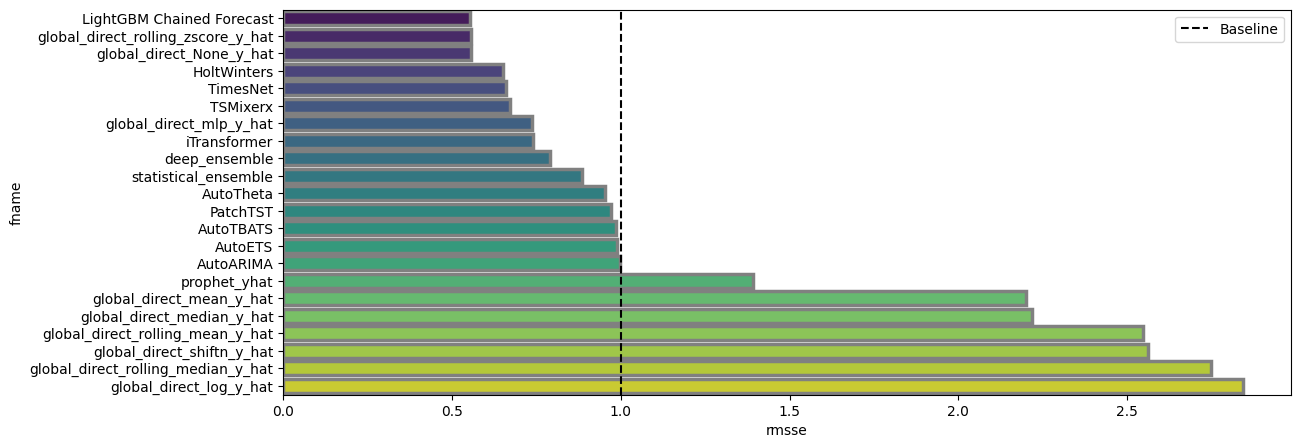

In [21]:
import seaborn as sns 
import matplotlib.pyplot as plt

rmsse_df = rmsse_df.loc[~rmsse_df["fname"].isin(['reference_y', 'all_ensemble', 'ensemble', 'lgb_ensemble', "local_direct_y_hat", "NBEATSx", "NHITS"])]
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", rmsse_df['fname'])
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", rmsse_df['fname'])
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_chain_y_hat", "LightGBM Chained Forecast", rmsse_df['fname'])

plt.figure(figsize=(13, 5))
sns.barplot(rmsse_df.sort_values(by="rmsse"), x="rmsse", y="fname",
            errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axvline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

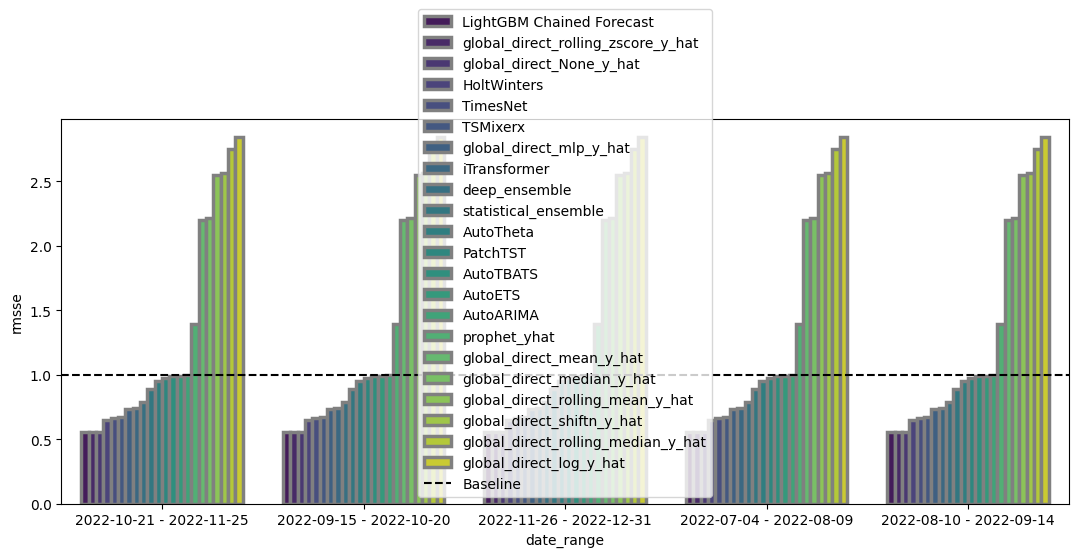

In [22]:
dt = baseline['date'].unique()
split_dt = np.array_split(dt, 5)
bycut = []
for sdt in split_dt:
    metrics_output_df = []
    b_cut = baseline.filter(pl.col("date").is_in(sdt))
    for col in forecast_cols:
        metrics_output_df.append(
            display_metrics(
            baseline[y].to_numpy(), 
            np.clip(baseline[col].fill_null(0).to_numpy(), a_min=0, a_max=None),
            name=col
            ).transpose()
        )

    allmet = pd.concat(metrics_output_df, axis=1)
    allmet.columns = allmet.iloc[0, :]
    rmsse_df = allmet.loc['rmse'] 
    rmsse_df /= rmsse_df['reference_y']
    rmsse_df = rmsse_df.to_frame('rmsse')
    rmsse_df['date_range'] = str(b_cut['date'].min()) + ' - ' + str(b_cut['date'].max())
    # display(allmet)
    bycut.append(rmsse_df)

import seaborn as sns 
import matplotlib.pyplot as plt

data_ = pd.concat(bycut).reset_index()
data_ = data_.loc[~data_["fname"].isin(['reference_y', 'all_ensemble', 'ensemble', 'lgb_ensemble', "local_direct_y_hat", "NBEATSx", "NHITS"])]
data_['fname'] = np.where(data_['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", data_['fname'])
data_['fname'] = np.where(data_['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", data_['fname'])
data_['fname'] = np.where(data_['fname'] == "global_chain_y_hat", "LightGBM Chained Forecast", data_['fname'])

plt.figure(figsize=(13, 5))
sns.barplot(data_.sort_values(by="rmsse"), x="date_range", y="rmsse", hue="fname",     errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axhline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

NameError: name 'subset' is not defined

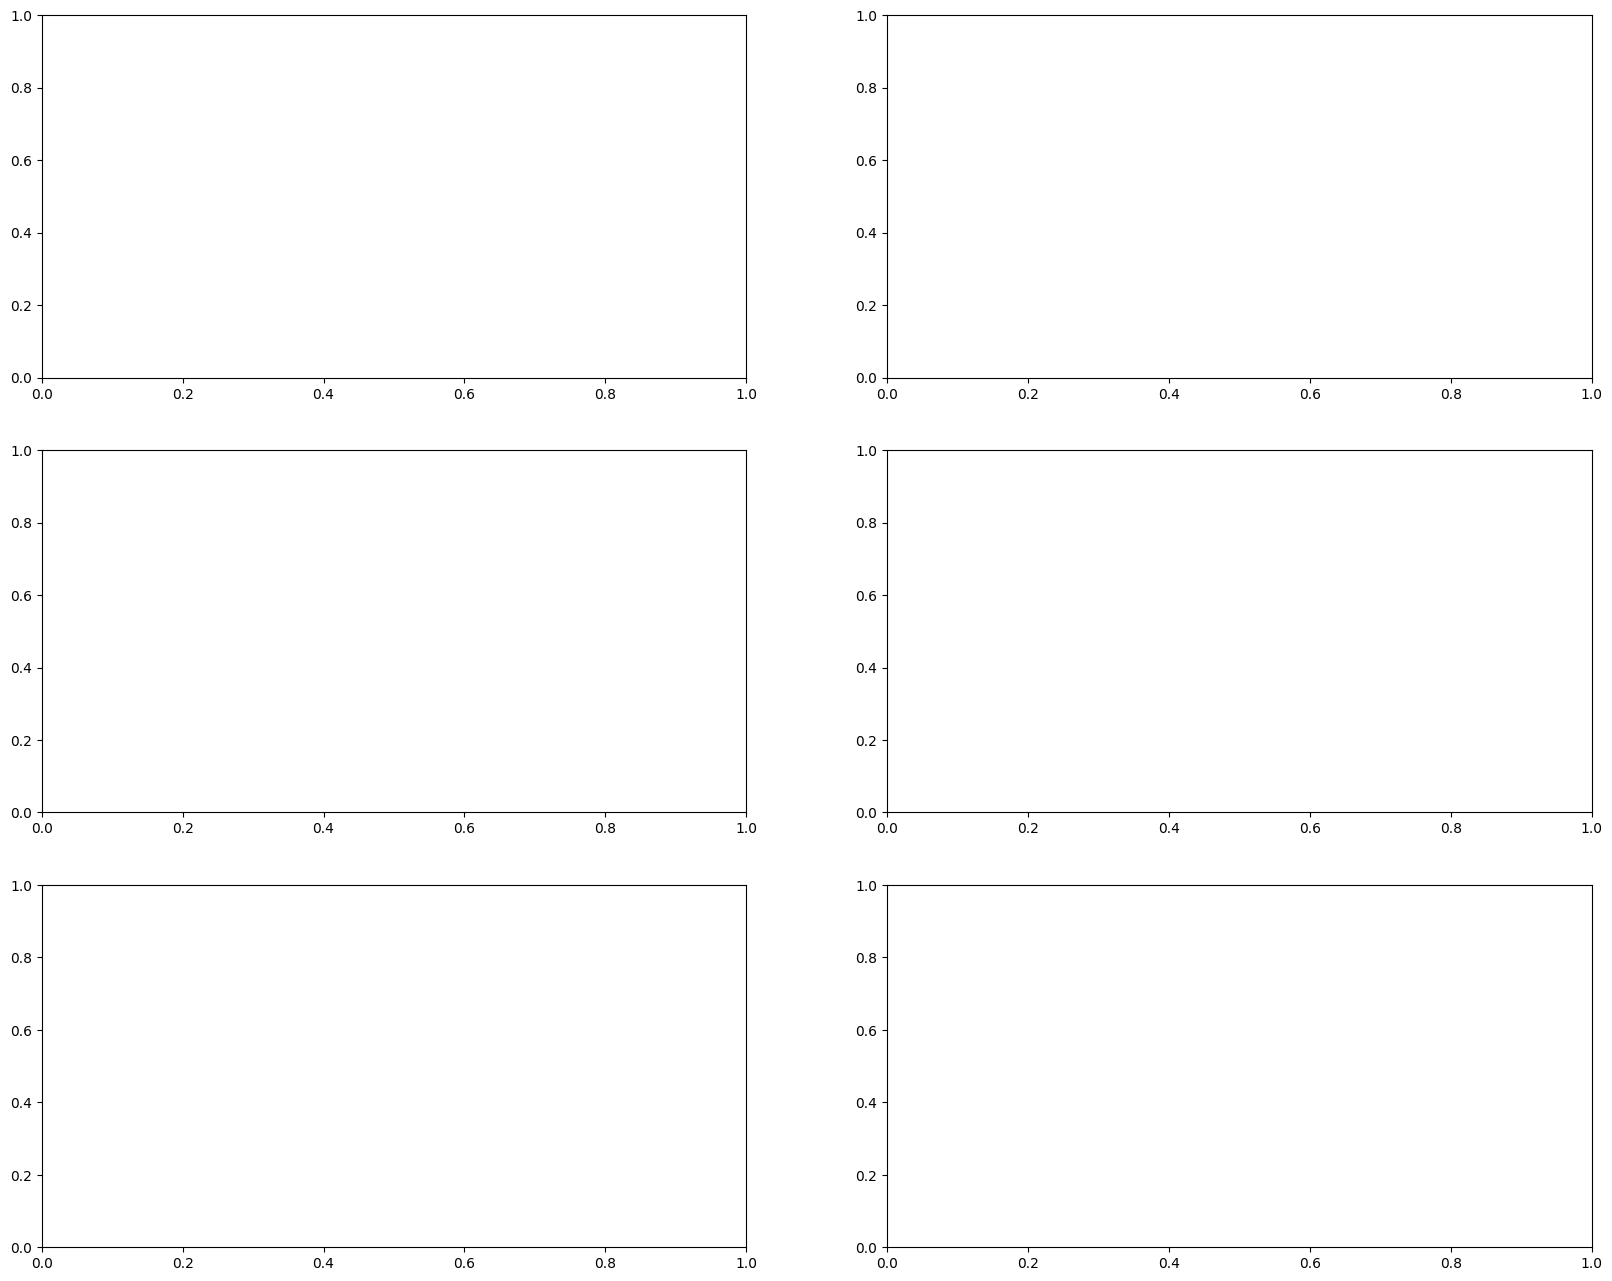

In [23]:
import matplotlib.pyplot as plt 

uids = baseline['station'].unique()
n = 6
choice = np.random.choice(uids, (n, ))

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(3, 2, figsize=(20, 16))
axs = axs.ravel()  # Aplatir le tableau 2D des axes pour itération facile

# Tracer les graphiques
for i, uid in enumerate(uids, start=0):
    if i  < n :
        subset_tr = train_data.filter(
            pl.col(ts_uid) == uid, 
            pl.col('date') >= pl.datetime(2021, 1, 1), 
            pl.col('date') < subset['date'].min()
            ).sort(by='date')
        subset = baseline.filter(pl.col(ts_uid) == uid).sort(by='date')
        axs[i].plot(subset_tr["date"], subset_tr['y_copy'], label="train", color="brown", alpha=0.8)
        axs[i].scatter(subset["date"], subset['y'], label="real", color="blue", alpha=1, marker="*")
        for col in list(filter(lambda x : 'y_hat' in x ,forecast_cols)):
            axs[i].scatter(subset["date"], subset[col], label=col, alpha=0.5, marker="x")
        axs[i].axvline(subset['date'].min())
        axs[i].set_title(f'Graph for ID {uid}')
        axs[i].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

overall_valid =  baseline.group_by('date').agg([pl.col(col).sum() for col in forecast_cols])
overall_hist =  train_data.filter(
            pl.col('date') >= pl.datetime(2021, 1, 1), 
            pl.col('date') < subset['date'].min()
            ).sort(by='date').group_by('date').agg(pl.col(y).sum())

overall_realise =  train_data.filter(
            pl.col('date') >= subset['date'].min()
            ).sort(by='date').group_by('date').agg(pl.col(y).sum())

plt.figure(figsize=(25, 6))
plt.scatter(
    overall_hist['date'], overall_hist['y'], label="train", marker="o"
)
plt.scatter(
    overall_realise['date'], overall_realise['y'], label="realise", marker="o"
)
for col in forecast_cols:
    plt.scatter(
        overall_valid['date'], overall_valid[col], label=f"{col}_valid", marker="*"
    )
plt.legend()